In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho']
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho']
lat_rho = np.transpose(lat_rho, axes=(1, 0))
z_r = np.load('/home/z5297792/MRes/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
h = dataset.variables['h']
h = np.transpose(h, (1, 0))
previous_file_idx = -1
TOTAL_NUM_DAYS = len(daydic)

In [4]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000  # in meters
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return EARTH_RADIUS * c

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    i_left = 0
    i_right = 0
    j_down = 0
    j_up = 0
    while (i_search - i_left >= 0 and 
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search], 
                    lat_rho[i_search - i_left, j_search], lon_rho[i_search - i_left, j_search])) < SEARCH_WIDTH/2:
        i_left += 1
    while (i_search + i_right < lon_rho.shape[0] and
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                    lat_rho[i_search + i_right, j_search], lon_rho[i_search + i_right, j_search])) < SEARCH_WIDTH/2:
        i_right += 1
    while (j_search - j_down >= 0 and 
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search], 
                    lat_rho[i_search, j_search - j_down], lon_rho[i_search, j_search - j_down])) < SEARCH_WIDTH/2:
        j_down += 1
    while (j_search + j_up < lon_rho.shape[1] and
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                    lat_rho[i_search, j_search + j_up], lon_rho[i_search, j_search + j_up])) < SEARCH_WIDTH/2:
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_up = min(j_search + j_up, lon_rho.shape[1])
    j_down = max(j_search - j_down + 1, 0)

    return i_left, i_right, j_down, j_up

EDDY = 'Eddy15'

WIDTH, LENGTH = lon_rho.shape
DAYS = eddies[EDDY].shape[0]

eVort = np.full((WIDTH, LENGTH, DAYS), np.nan)
eU = np.full((WIDTH, LENGTH, DAYS), np.nan)
eV = np.full((WIDTH, LENGTH, DAYS), np.nan)
for d in range(DAYS):

    edata = eddies[EDDY].iloc[d]
    t = extract_number(edata.name)
    
    t_mod = t % 30
    file_idx = np.floor(t/30)
    if file_idx != previous_file_idx:
        
        fnumber = '0'+str(round(1461+ file_idx*30))
        print(fnumber)
        vort = np.load('/srv/scratch/z5297792/Climatology/vorts/vort_'+fnumber+'.npy') 
        u = np.load('/srv/scratch/z5297792/Climatology/u_v/u_'+fnumber+'.npy')
        v = np.load('/srv/scratch/z5297792/Climatology/u_v/v_'+fnumber+'.npy')
        eVort[:, :, d] = vort[:, :, 5, t_mod]
        eU[:, :, d] = u[:, :, 5, t_mod]
        eV[:, :, d] = v[:, :, 5, t_mod]
        previous_file_idx = file_idx
    else:
        print(fnumber)
        eVort[:, :, d] = vort[:, :, 5, t_mod]
        eU[:, :, d] = u[:, :, 5, t_mod]
        eV[:, :, d] = v[:, :, 5, t_mod]

01461
01461
01461
01461
01461
01461
01461
01461
01461
01461
01461
01461
01461
01461
01461
01461
01461
01461
01461
01461
01461
01461
01461
01461
01461
01461
01461
01461
01461
01491
01491
01491
01491
01491
01491
01491
01491
01491
01491
01491
01491
01491
01491
01491
01491
01491
01491


In [12]:
eLat = np.full((WIDTH, LENGTH, DAYS), np.nan)
eLon = np.full((WIDTH, LENGTH, DAYS), np.nan)

for day in range(DAYS):

    edata = eddies[EDDY].iloc[day]
    
    surf_lon = edata.Lon
    surf_lat = edata.Lat
    R = distance(edata.Lat, edata.Lon, lat_rho, lon_rho)
    mask = R < 100000 #m
    eVort[:, :, day] = np.where(mask, eVort[:, :, day], np.nan) 
    eU[:, :, day] = np.where(mask, eU[:, :, day], np.nan) 
    eV[:, :, day] = np.where(mask, eV[:, :, day], np.nan) 
    eLat[:, :, day] = np.where(mask, lon_rho, np.nan) 
    eLon[:, :, day] = np.where(mask, lat_rho, np.nan) 

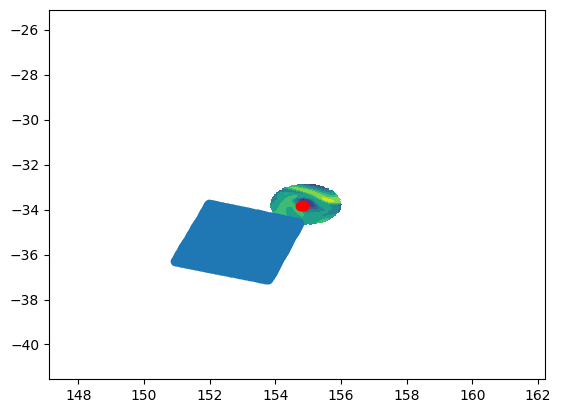

In [7]:
plt.contourf(lon_rho, lat_rho, eVort[:, :, 5])

i = list(range(90,180))
j = list(range(70,130))

i, j = np.meshgrid(i, j)

plt.scatter(lon_rho[i, j], lat_rho[i,j])

for l in range(5):
    edata = eddies[EDDY].iloc[l]
    
    plt.scatter(edata.Lon, edata.Lat, color='r')

## LAVD

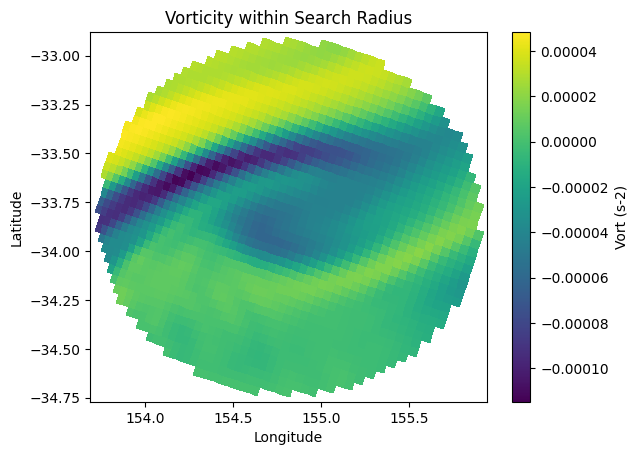

In [16]:
day = 1

edata = eddies[EDDY].iloc[day]

surf_lon = edata.Lon
surf_lat = edata.Lat
R = distance(edata.Lat, edata.Lon, lat_rho, lon_rho)
mask = R < 100000 #m
vort_masked = np.where(mask, eVort[:, :, day], np.nan) 
plt.pcolormesh(lon_rho, lat_rho, vort_masked)
plt.colorbar(label='Vort (s-2)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Vorticity within Search Radius')
plt.xlim([np.nanmin(np.where(mask,lon_rho,np.nan))-0.05,np.nanmax(np.where(mask,lon_rho,np.nan))+0.05])
plt.ylim([np.nanmin(np.where(mask,lat_rho,np.nan))-0.05,np.nanmax(np.where(mask,lat_rho,np.nan))+0.05])
plt.show()

In [50]:
for day in range(DAYS):

    edata = eddies[EDDY].iloc[day]
    
    surf_lon = edata.Lon
    surf_lat = edata.Lat
    R = distance(edata.Lat, edata.Lon, lat_rho, lon_rho)
    mask = R < 100000 #m
    eVort[:, :, day] = np.where(mask, eVort[:, :, day], np.nan) 


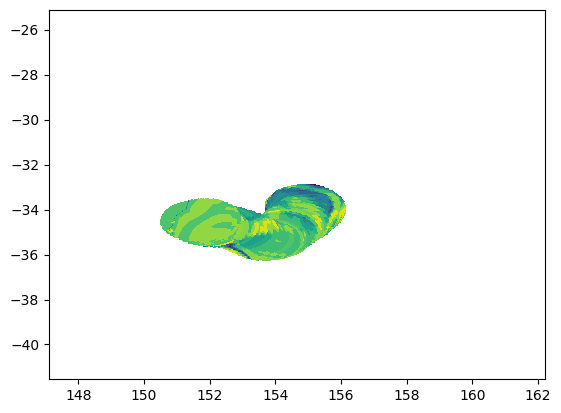

In [18]:
for d in range(DAYS):
    plt.contourf(lon_rho, lat_rho, eVort[:,:,d])

In [21]:
day = 5

w_bar = np.nanmean(eVort[:,:,day])
w = eVort[:,:,day]

LAVD = abs(w-w_bar)

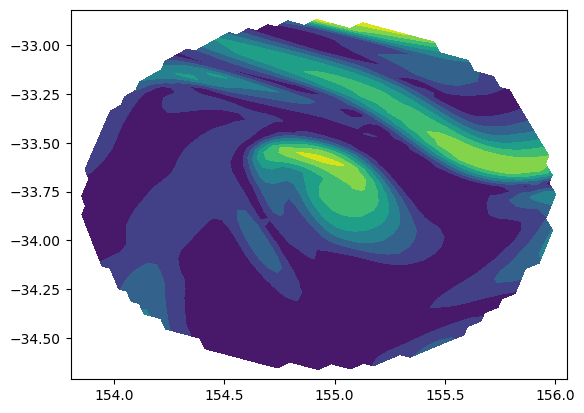

In [22]:
plt.contourf(lon_rho, lat_rho, LAVD)
mask = ~np.isnan(LAVD)
plt.xlim([np.nanmin(lon_rho[mask])-0.05, np.nanmax(lon_rho[mask])+0.05])
plt.ylim([np.nanmin(lat_rho[mask])-0.05, np.nanmax(lat_rho[mask])+0.05])

plt.show()

## Haller

In [60]:
def vorticity_along_trajectory(xp_t, yp_t, zp_t, u, v, tspan, rho):
    """
    Computes the z-component of vorticity along Lagrangian trajectories.

    Parameters:
    xp_t : np.ndarray
        x-component of Lagrangian trajectories
    yp_t : np.ndarray
        y-component of Lagrangian trajectories
    zp_t : np.ndarray
        z-component of Lagrangian trajectories
    u : function
        Function to compute the x-component of velocity at a given point in space and time: u(x, y, z, t)
    v : function
        Function to compute the y-component of velocity at a given point in space and time: v(x, y, z, t)
    tspan : np.ndarray
        Time span used for advecting particles
    rho : dict
        Auxiliary distances for computing vorticity along trajectories, with keys 'x' and 'y'

    Returns:
    Curlz_t : np.ndarray
        z-component of vorticity along trajectories
    """
    Nt, Np = xp_t.shape
    Curlz_t = np.zeros((Nt, Np))

    for kk in range(Nt):
        t = tspan[kk]
        
        # Initialize auxiliary grid velocities
        Nrad = 4
        ui = np.zeros((Np, Nrad))
        vi = np.zeros((Np, Nrad))
        
        for k in range(Nrad):
            angle = (k-1) * np.pi / 2
            xp_aug = xp_t[kk, :] + rho.x * np.cos(angle)
            yp_aug = yp_t[kk, :] + rho.y * np.sin(angle)
            zp_aug = zp_t[kk, :]
            
            ui[:, k] = u(xp_aug, yp_aug, zp_aug, np.full(Np, t))
            vi[:, k] = v(xp_aug, yp_aug, zp_aug, np.full(Np, t))
        
        # Compute velocity gradients
        grady_u = (ui[:, 1] - ui[:, 3]) / (2 * rho.y)
        gradx_v = (vi[:, 0] - vi[:, 2]) / (2 * rho.x)
        
        # Compute z-component of vorticity along trajectories
        Curlz_t[kk, :] = gradx_v - grady_u

    return Curlz_t

from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import ode

def integrator(xi, yi, zi, rho, tspan):
    """
    Integrator function to compute Lagrangian trajectories and vorticity.

    Parameters:
    xi : np.ndarray
        x-component of a two-dimensional grid of initial conditions
    yi : np.ndarray
        y-component of a two-dimensional grid of initial conditions
    zi : np.ndarray
        z-component of a two-dimensional grid of initial conditions
    rho : float
        Auxiliary distance for computing vorticity along trajectories
    tspan : np.ndarray
        Time span for advecting particles
    options : dict
        Options structure for ordinary differential equation solvers

    Returns:
    xp_t : np.ndarray
        x-component of Lagrangian trajectories
    yp_t : np.ndarray
        y-component of Lagrangian trajectories
    zp_t : np.ndarray
        z-component of Lagrangian trajectories
    Curlz_t : np.ndarray
        z-component of vorticity
    """
    
    # Interpolants
    u_interp = RegularGridInterpolator((lon, lat, depth, time), UT, method='linear', bounds_error=False, fill_value=None)
    v_interp = RegularGridInterpolator((lon, lat, depth, time), VT, method='linear', bounds_error=False, fill_value=None)
    w_interp = RegularGridInterpolator((lon, lat, depth, time), WT, method='linear', bounds_error=False, fill_value=None)

    # Velocity field functions
    def u(x, y, z, t):
        return u_interp((x, y, z, t))

    def v(x, y, z, t):
        return v_interp((x, y, z, t))

    def w(x, y, z, t):
        return w_interp((x, y, z, t))

    # ODE function
    def ODEfun(t, F, u, v, w):
        x, y, z = F[:len(F)//3], F[len(F)//3:2*len(F)//3], F[2*len(F)//3:]
        return np.concatenate([u(x, y, z, t), v(x, y, z, t), w(x, y, z, t)])

    # Initialize ODE solver
    solver = ode(ODEfun).set_integrator('dopri5', rtol=1e-3, atol=1e-3)
    solver.set_initial_value(np.concatenate([xi.flatten(), yi.flatten(), zi.flatten()]), tspan[0])
    solver.set_f_params(u, v, w)

    # Solve ODE
    F = [solver.y]
    for t in tspan[1:]:
        solver.integrate(t)
        F.append(solver.y)

    F = np.array(F)
    xp_t = F[:, :F.shape[1]//3]
    yp_t = F[:, F.shape[1]//3:2*F.shape[1]//3]
    zp_t = F[:, 2*F.shape[1]//3:]

    # Compute vorticity along trajectories
    Curlz_t = vorticity_along_trajectory(xp_t, yp_t, zp_t, u, v, tspan, rho)

    return xp_t, yp_t, zp_t, Curlz_t

previous_file_idx = -1


In [44]:
from scipy.interpolate import interp1d
def depth_interpolator(M,z_r,depths):
    dim_i, dim_j, dim_sigma, dim_time = M.shape
    assert z_r.shape == (dim_i, dim_j, dim_sigma)
    M_interpolated = np.zeros((dim_i, dim_j, len(depths), dim_time))
    for t in range(dim_time):
        for i in range(dim_i):
            for j in range(dim_j):
                depth_levels = z_r[i, j, :]
                values = M[i, j, :, t]
                if np.all(np.isnan(values)):
                    interpolated_values = np.full(len(depths), np.nan)
                else:
                    interpolator = interp1d(depth_levels, values, kind='linear', bounds_error=False, fill_value=np.nan)
                    interpolated_values = interpolator(depths)
                M_interpolated[i, j, :, t] = interpolated_values
        M_interpolated[:,:, 0, t] = M[:,:,0,t]
    return M_interpolated

In [45]:
EDDY = 'Eddy15'

i = list(range(90,180))
j = list(range(70,130))

i, j = np.meshgrid(i, j)

WIDTH, LENGTH = i.shape
SIGMAS = 30
# DAYS = eddies[EDDY].shape[0]
DAYS = 5

UT = np.full((WIDTH, LENGTH, SIGMAS, DAYS), np.nan)
VT = np.full((WIDTH, LENGTH, SIGMAS, DAYS), np.nan)
WT = np.full((WIDTH, LENGTH, SIGMAS, DAYS), np.nan)

z_r_cpy = z_r[i, j, :SIGMAS]

for d in range(DAYS):

    edata = eddies[EDDY].iloc[d]
    t = extract_number(edata.name)
    
    t_mod = t % 30
    file_idx = np.floor(t/30)
    if file_idx != previous_file_idx:
        
        fnumber = '0'+str(round(1461+ file_idx*30))
        fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_'+str(fnumber)+'.nc'
        dataset = nc.Dataset(fname)
        u = dataset.variables['u_eastward']
        u = np.transpose(u, axes=(3, 2, 1, 0))
        u = np.flip(u, axis=2)
        v = dataset.variables['v_northward']
        v = np.transpose(v, axes=(3, 2, 1, 0))
        v = np.flip(v, axis=2)
        w = dataset.variables['w']
        w = np.transpose(w, axes=(3, 2, 1, 0))
        w = np.flip(w, axis=2)
        w = w[:, :, 1:, :]

        u = u[i, j, :SIGMAS, :]
        v = v[i, j, :SIGMAS, :]
        w = w[i, j, :SIGMAS, :]

        u = depth_interpolator(u, z_r_cpy, z_r[150, 150, :SIGMAS])
        v = depth_interpolator(v, z_r_cpy, z_r[150, 150, :SIGMAS])
        w = depth_interpolator(w, z_r_cpy, z_r[150, 150, :SIGMAS])

        UT[:, :, :, d] = u[:, :, :, t_mod]
        VT[:, :, :, d] = v[:, :, :, t_mod]
        WT[:, :, :, d] = w[:, :, :, t_mod]
        
        previous_file_idx = file_idx
    else:
        UT[:, :, :, d] = u[:, :, :, t_mod]
        VT[:, :, :, d] = v[:, :, :, t_mod]
        WT[:, :, :, d] = w[:, :, :, t_mod]



SIGMAS = 20
UT = UT[:,:,:SIGMAS,:]
VT = VT[:,:,:SIGMAS,:]
WT = WT[:,:,:SIGMAS,:]
depth = z_r[150, 150, :SIGMAS]

lon = np.linspace(np.min(lon_rho[i,j]), np.max(lon_rho[i,j]), UT.shape[0])
lat = np.linspace(np.min(lat_rho[i,j]), np.max(lat_rho[i,j]), UT.shape[1])

In [11]:
day = 4
lvl = 5

CurSpeed = np.sqrt(UT[:,:,lvl,day]**2  + VT[:,:,lvl,day]**2)

plt.contourf(lon, lat,CurSpeed.T)

NameError: name 'UT' is not defined

In [103]:
time = [732812,
      732817,
      732822,
      732827,
      732832,
      732837,
      732842]

time = time[:DAYS]

time =list(range(732812, 732812+5))

t0 = time[0];
tf = time[-1];

Nt = 50;     
tspan = np.linspace(t0,tf,Nt); 

nx = 50 
ny = 60
nz = 60
x = np.linspace(11,16,nx)            
dx = float(abs(x[1]-x[0]))
y = np.linspace(-37,-33,ny)           
dy = float(abs(y[1]-y[0]))
z = np.linspace(7,2000,ny)*1e-3     
dz = float(abs(z[1]-z[0]))
[xi,yi,zi] = np.meshgrid(x,y,z)

rho = pd.DataFrame({})
rho.x = .5 * dx
rho.y = .5 * dy
rho.z = .5 * dz


In [104]:
xp_t, yp_t, zp_t, Curlz_t = integrator(xi, yi, zi, rho, tspan)

In [105]:
xp_t_cpy = xp_t
yp_t_cpy = yp_t
zp_t_cpy = zp_t
Curlz_t_cpy = Curlz_t

In [106]:
Curlz_avg_t = np.mean(Curlz_t, axis=1)
IVD = np.abs(Curlz_t[0, :] - Curlz_avg_t[0])
LAVD = np.trapezoid(np.abs(Curlz_t - Curlz_avg_t[:, np.newaxis]), tspan, axis=0)

In [114]:
VMatrix = np.reshape(LAVD,(ny,nx,nz))

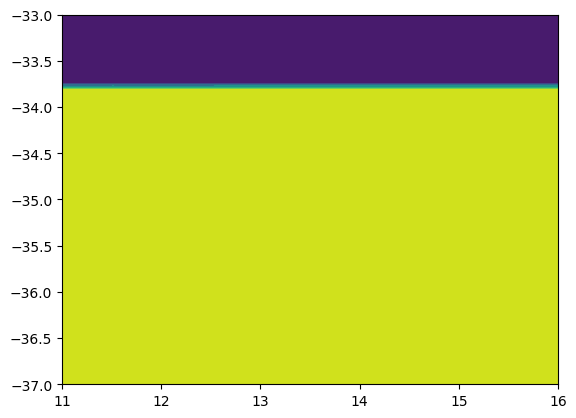

In [115]:
plt.contourf(x,y,VMatrix[:,:,0])

## Parcels

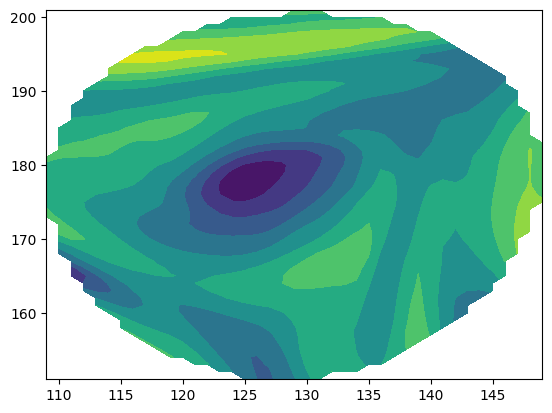

In [10]:
matrix_slice = eVort[:, :, 13] #t=7:13

non_nan_rows = np.any(~np.isnan(matrix_slice), axis=1)
non_nan_cols = np.any(~np.isnan(matrix_slice), axis=0)

y_min, y_max = np.where(non_nan_rows)[0][[0, -1]]
x_min, x_max = np.where(non_nan_cols)[0][[0, -1]]

plt.contourf(eLon, eLat, matrix_slice)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

In [21]:
import math
from datetime import timedelta
from operator import attrgetter

import matplotlib.pyplot as plt
import numpy as np
import trajan as ta
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

import parcels

In [67]:
lon = np.moveaxis(eLon, -1, 0)
lat = np.moveaxis(eLat, -1, 0)

# U = np.nan_to_num(U, nan=0)
# V = np.nan_to_num(V, nan=0)

start = 0
stop = 47 * 24 * 60 * 60  # 47 days in seconds
step = 24 * 60 * 60  # 1 day in seconds
time = np.arange(start, stop + step, step)

In [102]:
grid  = dataset.variables['grid']

In [106]:
grid.get_dims

<bound method Variable.get_dims of <class 'netCDF4._netCDF4.Variable'>
int32 grid()
    cf_role: grid_topology
    topology_dimension: 2
    node_dimensions: xi_psi eta_psi
    face_dimensions: xi_rho: xi_psi (padding: both) eta_rho: eta_psi (padding: both)
    edge1_dimensions: xi_u: xi_psi eta_u: eta_psi (padding: both)
    edge2_dimensions: xi_v: xi_psi (padding: both) eta_v: eta_psi
    node_coordinates: lon_psi lat_psi
    face_coordinates: lon_rho lat_rho
    edge1_coordinates: lon_u lat_u
    edge2_coordinates: lon_v lat_v
    vertical_dimensions: s_rho: s_w (padding: none)
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of -2147483647 used>

In [103]:


U1 = parcels.field.Field('U', U,transpose=True,grid=grid)






TypeError: len() of unsized object

In [61]:
fieldset = parcels.fieldset.FieldSet(U, V, fields=None)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [79]:
lat_rho[0,:].shape

(317,)

In [80]:
lon_rho[:,0].shape

(272,)

In [101]:
U.shape

(272, 317, 47)